In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
from supabase import create_client
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

# comparing 2 tables of embeddings here
SUPABASE_URL = ""   
SUPABASE_ANON_KEY = ""                
TABLE_1 = "documents"        
TABLE_2 = "new_documents"    
ID_COL = "id"                
CONTENT_COL = "content"      
EMBED_COL = "embedding"      
METADATA_COL = "metadata"    

## Analysis toggles
# If True, L2-normalize embeddings before KMeans/silhouette (makes Euclidean behave like cosine on the unit sphere)
NORMALIZE_FOR_CLUSTER = True

# Silhouette metric: 'euclidean' (default) or 'cosine'
# If NORMALIZE_FOR_CLUSTER=True and metric='euclidean', you get cosine-consistent behavior with standard KMeans stability.
SILHOUETTE_METRIC = 'euclidean'



In [25]:
# Cell 2 - helper functions
def connect_supabase(url: str, key: str):
    return create_client(url, key)

def fetch_table_embeddings(supabase_client, table_name: str, id_col=ID_COL, content_col=CONTENT_COL, embed_col=EMBED_COL, metadata_col=METADATA_COL, limit=None):
    """
    Fetch id, content, embedding, metadata from a Supabase table.
    Returns a pandas DataFrame with columns: id, content, embedding (numpy array), metadata
    Compatible with current supabase-py APIResponse (no status_code attr).
    """
    # Build select string. We assume 'embedding' is stored as vector and returned as list/array by supabase client
    select_cols = f"{id_col},{content_col},{embed_col},{metadata_col}"
    query = supabase_client.table(table_name).select(select_cols)
    if limit is not None:
        query = query.limit(limit)
    resp = query.execute()

    # Handle APIResponse variations across sdk versions
    data = getattr(resp, "data", None)
    error = getattr(resp, "error", None)
    # Some older/newer versions may use dict-like return
    if data is None and isinstance(resp, dict):
        data = resp.get("data")
        error = resp.get("error")

    if error:
        raise RuntimeError(f"Supabase query error: {error}")
    if data is None:
        # Last resort: try to read common attrs
        maybe_text = getattr(resp, "text", "<no-text>")
        raise RuntimeError(f"Supabase query returned no data. Raw response: {maybe_text}")
    if not data:
        return pd.DataFrame(columns=[id_col, content_col, embed_col, metadata_col])

    df = pd.DataFrame(data)
    # Convert embedding column to numpy arrays
    def to_array(x):
        if x is None:
            return None
        # x may already be list/tuple or string; attempt to parse if string
        if isinstance(x, str):
            # remove brackets if present and split
            s = x.strip()
            s = s.strip("[]")
            if s == "":
                return np.array([])
            return np.array([float(v) for v in s.split(",")], dtype=float)
        if isinstance(x, (list, tuple)):
            return np.array(x, dtype=float)
        if isinstance(x, dict) and "values" in x:
            return np.array(x["values"], dtype=float)
        # fallback
        return np.array(x, dtype=float)

    # Ensure required columns exist even if some fields missing
    for col in [id_col, content_col, embed_col, metadata_col]:
        if col not in df.columns:
            df[col] = None

    df[embed_col] = df[embed_col].apply(to_array)
    # drop rows with missing/empty embeddings
    df = df[df[embed_col].apply(lambda e: (e is not None) and (getattr(e, "size", 0) > 0))].reset_index(drop=True)
    return df


In [ ]:
# Cell 3 - metric functions

def compute_knn_cohesion(embeddings: np.ndarray, k: int = 5):
    """
    For each vector compute average cosine similarity to its k nearest neighbors (excluding itself).
    Returns an array of per-item cohesion scores and the global average.
    """
    n = embeddings.shape[0]
    if n <= 1:
        return np.array([0.0]), 0.0
    # compute cosine similarity matrix (n x n)
    sim = cosine_similarity(embeddings)
    # for each i, set self-similarity to -inf so it's excluded
    np.fill_diagonal(sim, -np.inf)
    k_eff = min(k, n-1)
    # get top-k similarities
    topk = np.partition(sim, -k_eff, axis=1)[:, -k_eff:]
    per_item = topk.mean(axis=1)
    global_avg = per_item.mean()
    return per_item, float(global_avg)


def compute_inter_embedding_redundancy(embeddings: np.ndarray, sample_pairs: int = 20000, seed: int = 42):
    """
    Compute sample-based average pairwise cosine similarity across embeddings (redundancy).
    For efficiency, sample up to sample_pairs random pairs (i,j).
    Returns sampled similarities and the average redundancy.
    """
    rng = np.random.default_rng(seed)
    n = embeddings.shape[0]
    if n <= 1:
        return np.array([0.0]), 0.0
    # If dataset small, compute all pairwise
    max_pairs = n*(n-1)//2
    if max_pairs <= sample_pairs:
        # compute full pairwise upper triangle
        sim = cosine_similarity(embeddings)
        iu = np.triu_indices(n, k=1)
        vals = sim[iu]
        return vals, float(vals.mean())
    # otherwise sample pairs
    idxs = rng.integers(0, n, size=(sample_pairs, 2))
    # ensure i != j
    mask = idxs[:,0] != idxs[:,1]
    idxs = idxs[mask]
    # compute similarities in batches to avoid memory issues
    vals = []
    batch = 4096
    for i in range(0, len(idxs), batch):
        batch_idxs = idxs[i:i+batch]
        a = embeddings[batch_idxs[:,0]]
        b = embeddings[batch_idxs[:,1]]
        # elementwise cosine similarity
        # cosine_similarity can do pairwise for two sets:
        sims = (a * b).sum(axis=1) / (np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1))
        vals.append(sims)
    if vals:
        vals = np.concatenate(vals)
    else:
        vals = np.array([])
    return vals, float(vals.mean() if vals.size else 0.0)


def compute_best_silhouette(embeddings: np.ndarray, k_min=2, k_max=8, random_state=0, normalize: bool = False, metric: str = 'euclidean'):
    """
    Run KMeans for k in [k_min, k_max], return best silhouette score and corresponding labels & k.
    Optionally L2-normalize before clustering/silhouette, and allow silhouette metric selection ('euclidean'|'cosine').
    If too few points for clustering returns (score=nan, k=None, labels=None).
    """
    n = embeddings.shape[0]
    if n < 2:
        return float("nan"), None, None
    # limit k_max by n-1
    k_max = min(k_max, max(2, n-1))
    X = embeddings.astype(float, copy=False)
    if normalize:
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        norms[norms == 0] = 1.0
        X = X / norms
    best_score = -1.0
    best_k = None
    best_labels = None
    for k in range(k_min, k_max+1):
        try:
            km = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(X)
            lab = km.labels_
            sc = silhouette_score(X, lab, metric=metric)
            if sc > best_score:
                best_score = sc
                best_k = k
                best_labels = lab
        except Exception:
            continue
    if best_k is None:
        return float("nan"), None, None
    return float(best_score), int(best_k), np.array(best_labels)


In [ ]:
# Cell 4 - run analysis for a single DataFrame

def analyze_table(df: pd.DataFrame, embed_col=EMBED_COL, name="table", k_nn=5, sample_pairs=20000):
    """
    Returns a dict with metrics and shows histograms.
    """
    print(f"\n--- Analyzing {name}: {len(df)} embeddings ---")
    embeddings = np.stack(df[embed_col].values, axis=0)
    # normalize tiny numerical issues
    norms = np.linalg.norm(embeddings, axis=1)
    zero_norms = np.where(norms == 0)[0]
    if zero_norms.size:
        # small handling: replace zero vectors with tiny noise to avoid NaNs
        embeddings[zero_norms] = embeddings[zero_norms] + 1e-12
        norms = np.linalg.norm(embeddings, axis=1)

    per_item_cohesion, avg_cohesion = compute_knn_cohesion(embeddings, k=k_nn)
    sample_sims, avg_redundancy = compute_inter_embedding_redundancy(embeddings, sample_pairs=sample_pairs)
    sil_score, best_k, labels = compute_best_silhouette(
        embeddings,
        k_min=2,
        k_max=min(8, max(2, embeddings.shape[0]-1)),
        normalize=bool(globals().get('NORMALIZE_FOR_CLUSTER', False)),
        metric=str(globals().get('SILHOUETTE_METRIC', 'euclidean'))
    )

    # Print metrics
    print(f"Avg. {k_nn}-NN cohesion: {avg_cohesion:.4f}")
    print(f"Avg. pairwise redundancy (sampled): {avg_redundancy:.4f}")
    if not math.isnan(sil_score):
        print(f"Best silhouette score (KMeans k={best_k}, metric={globals().get('SILHOUETTE_METRIC', 'euclidean')}, norm={globals().get('NORMALIZE_FOR_CLUSTER', False)}): {sil_score:.4f}")
    else:
        print("Silhouette score: N/A (too few points or clustering failed)")

    # Histograms
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].hist(per_item_cohesion, bins=40)
    axes[0].set_title(f"{name}: per-embedding {k_nn}-NN cohesion distribution\n(mean={avg_cohesion:.4f})")
    axes[0].set_xlabel("Cosine similarity (to neighbors)")
    axes[0].set_ylabel("Count")

    axes[1].hist(sample_sims, bins=40)
    axes[1].set_title(f"{name}: sampled inter-embedding similarity distribution\n(mean={avg_redundancy:.4f})")
    axes[1].set_xlabel("Pairwise cosine similarity")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    return {
        "n_embeddings": int(len(df)),
        "avg_cohesion": float(avg_cohesion),
        "per_item_cohesion": per_item_cohesion,
        "avg_redundancy": float(avg_redundancy),
        "sample_sims": sample_sims,
        "silhouette": float(sil_score) if not math.isnan(sil_score) else None,
        "best_k": best_k,
        "labels": labels
    }


Fetching table 1: documents
Fetching table 2: new_documents
Fetching table 2: new_documents

--- Analyzing documents: 314 chunks ---

--- Analyzing documents: 314 chunks ---
Avg. 5-NN cohesion: 0.7346
Avg. pairwise redundancy (sampled): 0.3909
Best silhouette score (KMeans k=2, metric=euclidean, norm=True): 0.1239
Avg. 5-NN cohesion: 0.7346
Avg. pairwise redundancy (sampled): 0.3909
Best silhouette score (KMeans k=2, metric=euclidean, norm=True): 0.1239


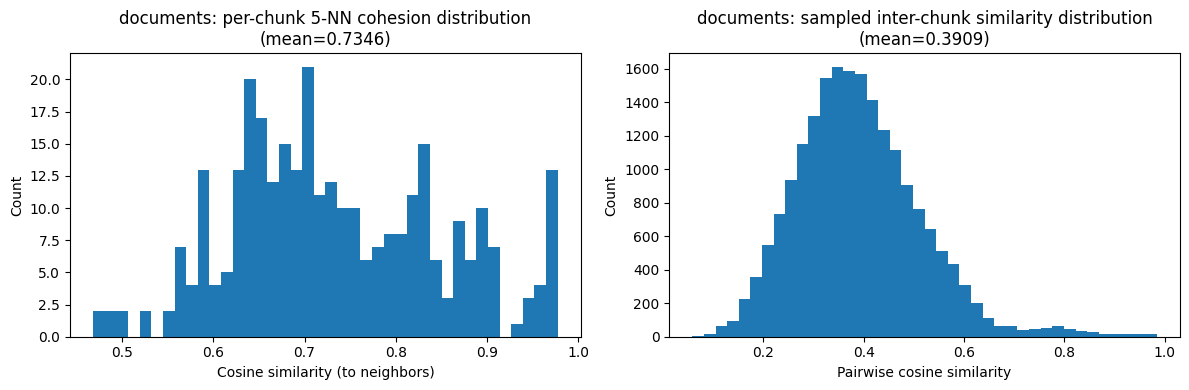


--- Analyzing new_documents: 188 chunks ---
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3932
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1267
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3932
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1267


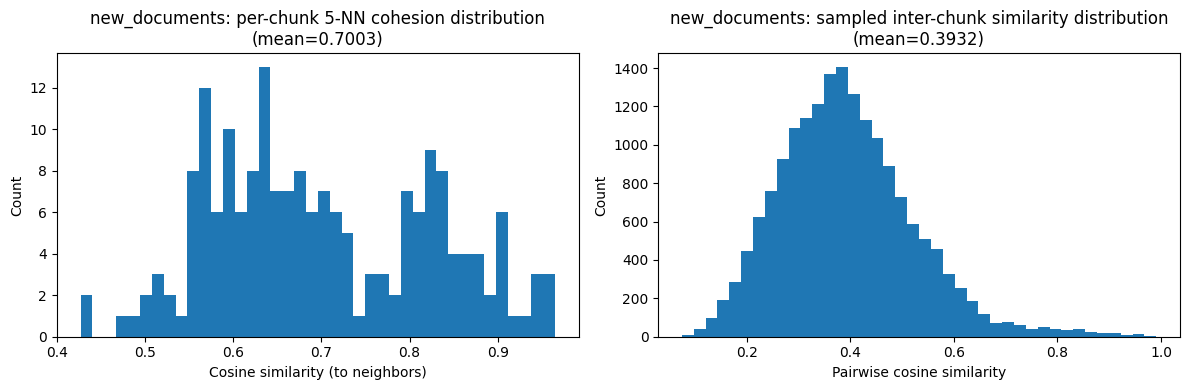

In [28]:
# Cell 5 - pipeline
client = connect_supabase(SUPABASE_URL, SUPABASE_ANON_KEY)

print("Fetching table 1:", TABLE_1)
df1 = fetch_table_embeddings(client, TABLE_1, id_col=ID_COL, content_col=CONTENT_COL, embed_col=EMBED_COL, metadata_col=METADATA_COL)
print("Fetching table 2:", TABLE_2)
df2 = fetch_table_embeddings(client, TABLE_2, id_col=ID_COL, content_col=CONTENT_COL, embed_col=EMBED_COL, metadata_col=METADATA_COL)

# Basic sanity checks
if df1.empty:
    print(f"Warning: table {TABLE_1} returned no rows or embeddings.")
if df2.empty:
    print(f"Warning: table {TABLE_2} returned no rows or embeddings.")

# Analyze both (you can adjust k_nn and sample_pairs)
res1 = analyze_table(df1, embed_col=EMBED_COL, name=TABLE_1, k_nn=5, sample_pairs=20000)
res2 = analyze_table(df2, embed_col=EMBED_COL, name=TABLE_2, k_nn=5, sample_pairs=20000)


In [ ]:
# Cell 6 - compare and scoring

def compare_tables(resA: dict, resB: dict, nameA: str, nameB: str):
    """
    Compare by metrics and produce a final simple ranking.
    Score components:
      - avg_cohesion: higher is better (weight 0.45)
      - avg_redundancy: lower is better (weight 0.35)
      - silhouette: higher is better (weight 0.20) (if present)
    """
    w_cohesion = 0.45
    w_redund = 0.35
    w_sil = 0.20

    # normalize metrics to comparable scales:
    # cohesion roughly in [-1,1], redundancy in [-1,1], silhouette in [-1,1]
    # We'll transform so higher-is-better in [0,1] by shift/scale
    def to_unit_positive(x):
        # map from [-1,1] to [0,1]
        return (x + 1.0) / 2.0

    A_coh = to_unit_positive(resA["avg_cohesion"])
    B_coh = to_unit_positive(resB["avg_cohesion"])
    A_red = to_unit_positive(-resA["avg_redundancy"])  # lower redundancy better -> invert
    B_red = to_unit_positive(-resB["avg_redundancy"])
    A_sil = to_unit_positive(resA["silhouette"]) if resA.get("silhouette") is not None else 0.5
    B_sil = to_unit_positive(resB["silhouette"]) if resB.get("silhouette") is not None else 0.5

    scoreA = w_cohesion * A_coh + w_redund * A_red + w_sil * A_sil
    scoreB = w_cohesion * B_coh + w_redund * B_red + w_sil * B_sil

    summary = pd.DataFrame([
        {
            "table": nameA,
            "n_embeddings": resA["n_embeddings"],
            "avg_cohesion": resA["avg_cohesion"],
            "avg_redundancy": resA["avg_redundancy"],
            "silhouette": resA["silhouette"],
            "composite_score": scoreA
        },
        {
            "table": nameB,
            "n_embeddings": resB["n_embeddings"],
            "avg_cohesion": resB["avg_cohesion"],
            "avg_redundancy": resB["avg_redundancy"],
            "silhouette": resB["silhouette"],
            "composite_score": scoreB
        }
    ])
    winner = nameA if scoreA > scoreB else nameB if scoreB > scoreA else "tie"
    print("\n=== Comparison Summary ===")
    display(summary.sort_values("composite_score", ascending=False).reset_index(drop=True))
    print(f"\nWinner by composite score: {winner}")
    # Give reasoning
    print("\nReasoning:")
    print(f"- {nameA}: cohesion={resA['avg_cohesion']:.4f}, redundancy={resA['avg_redundancy']:.4f}, silhouette={resA['silhouette']}")
    print(f"- {nameB}: cohesion={resB['avg_cohesion']:.4f}, redundancy={resB['avg_redundancy']:.4f}, silhouette={resB['silhouette']}")
    return summary, winner

summary_df, winner = compare_tables(res1, res2, TABLE_1, TABLE_2)



=== Comparison Summary ===


,table,n_chunks,avg_cohesion,avg_redundancy,silhouette,composite_score
0,documents,314,0.734588,0.390915,0.123862,0.609258
1,new_documents,188,0.700331,0.393150,0.126704,0.601444



Winner by composite score: documents

Reasoning:
- documents: cohesion=0.7346, redundancy=0.3909, silhouette=0.1238621792634648
- new_documents: cohesion=0.7003, redundancy=0.3932, silhouette=0.126704197370908


Group counts (documents):
metadata
a749066c4fcddec8    188
6fd5dbdf5919a84a    126
Name: count, dtype: int64

Group counts (new_documents):
metadata
a749066c4fcddec8    188
Name: count, dtype: int64

Target group for fair comparison: 'a749066c4fcddec8'
Subset sizes -> documents[a749066c4fcddec8]: 188 | new_documents[a749066c4fcddec8]: 188

--- Analyzing documents[a749066c4fcddec8]: 188 chunks ---
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3931
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1206
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3931
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1206


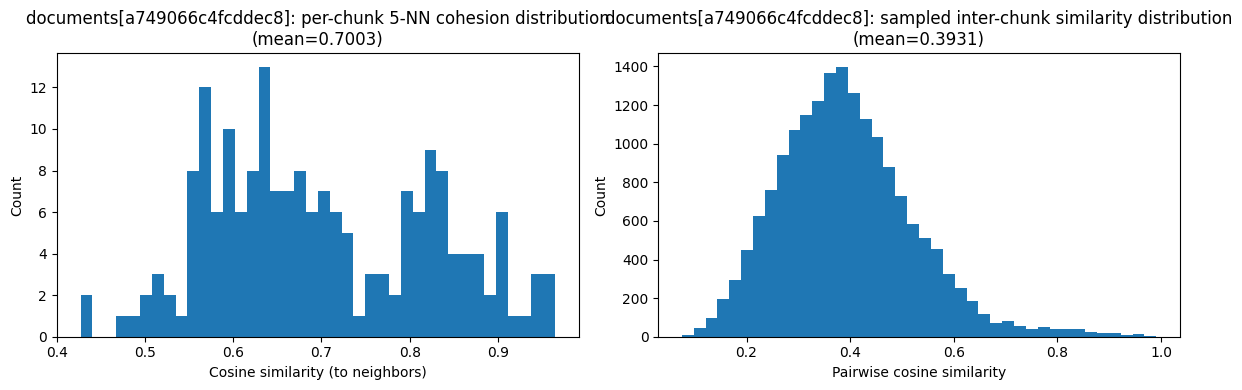


--- Analyzing new_documents[a749066c4fcddec8]: 188 chunks ---
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3932
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1267
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3932
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1267


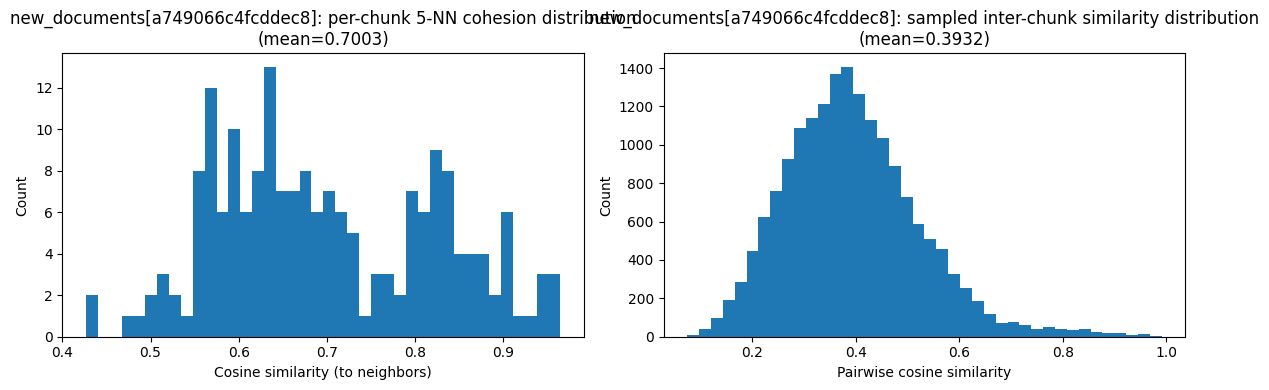


=== Comparison Summary ===


,table,n_chunks,avg_cohesion,avg_redundancy,silhouette,composite_score
0,new_documents[a749066c4fcddec8],188,0.700331,0.393150,0.126704,0.601444
1,documents[a749066c4fcddec8],188,0.700285,0.393104,0.120600,0.600831



Winner by composite score: new_documents[a749066c4fcddec8]

Reasoning:
- documents[a749066c4fcddec8]: cohesion=0.7003, redundancy=0.3931, silhouette=0.12059975941368935
- new_documents[a749066c4fcddec8]: cohesion=0.7003, redundancy=0.3932, silhouette=0.126704197370908


In [ ]:
# Cell 6a - control for multi-document composition
from collections import Counter
import os, re

def extract_doc_group(meta):
    """Return a short identifier for the source document if possible (e.g., filename stem)."""
    try:
        if meta is None:
            return None
        if isinstance(meta, dict):
            # Look for common keys
            for key in ["doc_id", "document_id", "source_id", "source", "file", "filename", "name", "doc", "title", "path"]:
                if key in meta and meta[key]:
                    val = str(meta[key])
                    base = os.path.basename(val)
                    stem = os.path.splitext(base)[0]
                    return stem.lower() if stem else str(val).lower()
            s = str(meta)
        else:
            s = str(meta)
        # Try to detect a filename-like token ending in .pdf
        m = re.search(r"([\w\-]+)\.pdf", s, flags=re.IGNORECASE)
        if m:
            return m.group(1).lower()
        # Fallback: pick a reasonable token
        tokens = re.findall(r"[A-Za-z0-9_\-]{4,}", s)
        return tokens[0].lower() if tokens else None
    except Exception:
        return None

def make_groups(df: pd.DataFrame, metadata_col=METADATA_COL):
    if metadata_col in df.columns:
        groups = df[metadata_col].apply(extract_doc_group)
    else:
        groups = pd.Series([None] * len(df), index=df.index)
    return groups.fillna("unknown")

# Build group labels for both tables
g1 = make_groups(df1, METADATA_COL)
g2 = make_groups(df2, METADATA_COL)

print("Group counts (documents):")
print(g1.value_counts().head(10))
print("\nGroup counts (new_documents):")
print(g2.value_counts().head(10))

# Choose target group as the dominant non-'unknown' group in new_documents
dom_groups_df2 = [g for g, c in Counter(g2).most_common() if g != "unknown"]
target_group = dom_groups_df2[0] if dom_groups_df2 else "unknown"
print(f"\nTarget group for fair comparison: {target_group!r}")

df1_same = df1[g1 == target_group].reset_index(drop=True)
df2_same = df2[g2 == target_group].reset_index(drop=True)

print(f"Subset sizes -> documents[{target_group}]: {len(df1_same)} | new_documents[{target_group}]: {len(df2_same)}")

if len(df1_same) >= 2 and len(df2_same) >= 2:
    res1_same = analyze_table(df1_same, embed_col=EMBED_COL, name=f"{TABLE_1}[{target_group}]", k_nn=5, sample_pairs=20000)
    res2_same = analyze_table(df2_same, embed_col=EMBED_COL, name=f"{TABLE_2}[{target_group}]", k_nn=5, sample_pairs=20000)
    summary_df_same, winner_same = compare_tables(res1_same, res2_same, f"{TABLE_1}[{target_group}]", f"{TABLE_2}[{target_group}]")
else:
    print("Not enough data in one of the subsets to compute a fair comparison (need at least 2 embeddings each).")

Equalized sampling on group 'a749066c4fcddec8': n1=188, n2=188, using n_equal=188

--- Analyzing documents[a749066c4fcddec8]-equalized: 188 chunks ---
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3931
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1218
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3931
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1218


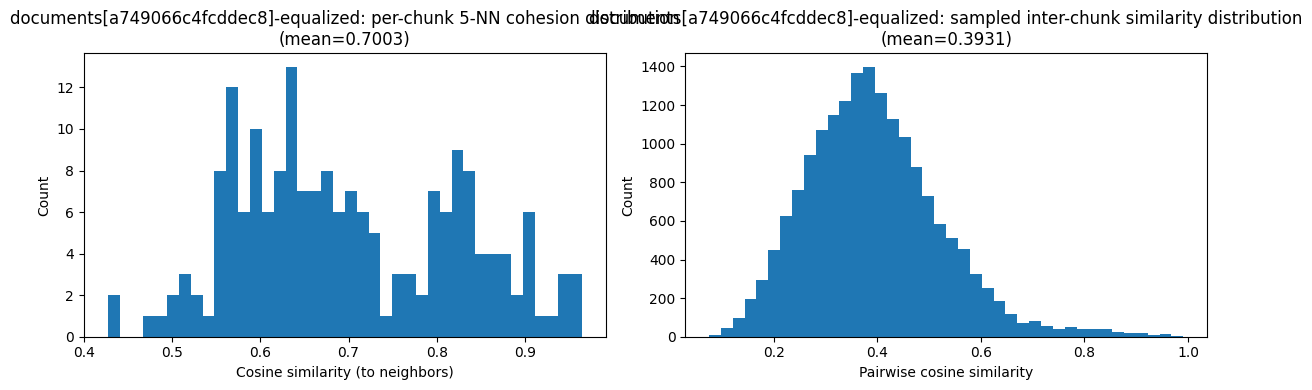


--- Analyzing new_documents[a749066c4fcddec8]-equalized: 188 chunks ---
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3932
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1211
Avg. 5-NN cohesion: 0.7003
Avg. pairwise redundancy (sampled): 0.3932
Best silhouette score (KMeans k=3, metric=euclidean, norm=True): 0.1211


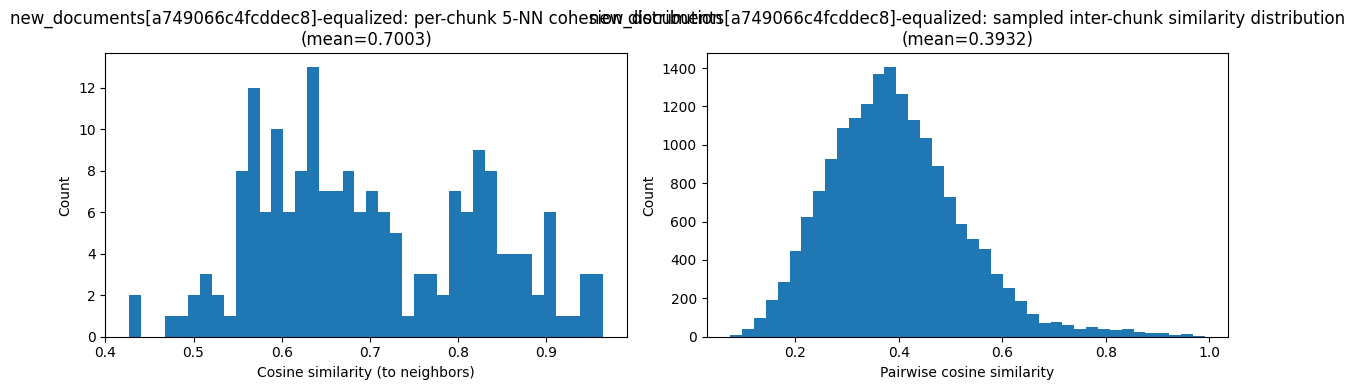


=== Comparison Summary ===


,table,n_chunks,avg_cohesion,avg_redundancy,silhouette,composite_score
0,documents[a749066c4fcddec8]-eq,188,0.700285,0.393104,0.121832,0.600954
1,new_documents[a749066c4fcddec8]-eq,188,0.700331,0.393150,0.121085,0.600882



Winner by composite score: documents[a749066c4fcddec8]-eq

Reasoning:
- documents[a749066c4fcddec8]-eq: cohesion=0.7003, redundancy=0.3931, silhouette=0.12183229174529023
- new_documents[a749066c4fcddec8]-eq: cohesion=0.7003, redundancy=0.3932, silhouette=0.1210854378115759


In [ ]:
# Cell 6b - equalized sampling fairness check
import numpy as np

# Use the same target_group chosen in Cell 6a (dominant group in new_documents)
if 'target_group' in globals():
    df1_pdf1 = df1[g1 == target_group].reset_index(drop=True)
    df2_pdf1 = df2[g2 == target_group].reset_index(drop=True)
else:
    # Recompute if cell order ran differently
    g1 = make_groups(df1, METADATA_COL)
    g2 = make_groups(df2, METADATA_COL)
    from collections import Counter
    dom_groups_df2 = [g for g, c in Counter(g2).most_common() if g != "unknown"]
    target_group = dom_groups_df2[0] if dom_groups_df2 else "unknown"
    df1_pdf1 = df1[g1 == target_group].reset_index(drop=True)
    df2_pdf1 = df2[g2 == target_group].reset_index(drop=True)

n1, n2 = len(df1_pdf1), len(df2_pdf1)
n_equal = min(n1, n2)

print(f"Equalized sampling on group {target_group!r}: n1={n1}, n2={n2}, using n_equal={n_equal}")

if n_equal >= 2:
    rng = np.random.default_rng(0)
    ix1 = rng.choice(n1, size=n_equal, replace=False)
    ix2 = rng.choice(n2, size=n_equal, replace=False)
    df1_eq = df1_pdf1.iloc[ix1].reset_index(drop=True)
    df2_eq = df2_pdf1.iloc[ix2].reset_index(drop=True)

    res1_eq = analyze_table(df1_eq, embed_col=EMBED_COL, name=f"{TABLE_1}[{target_group}]-equalized", k_nn=5, sample_pairs=20000)
    res2_eq = analyze_table(df2_eq, embed_col=EMBED_COL, name=f"{TABLE_2}[{target_group}]-equalized", k_nn=5, sample_pairs=20000)
    summary_df_eq, winner_eq = compare_tables(res1_eq, res2_eq, f"{TABLE_1}[{target_group}]-eq", f"{TABLE_2}[{target_group}]-eq")
else:
    print("Not enough data to perform equalized sampling (need at least 2 embeddings in each subset).")

In [ ]:
# Cell 7 - show extremes for manual checking

def show_extremes(df: pd.DataFrame, per_item_cohesion: np.ndarray, top_n=5):
    ix_sorted = np.argsort(per_item_cohesion)[::-1]  # high -> low
    print("\nTop coherent embeddings:")
    for i in ix_sorted[:top_n]:
        print(f"--- idx {i} cohesion={per_item_cohesion[i]:.4f} ---")
        print(df.iloc[i][CONTENT_COL])
        print()
    print("\nLeast coherent embeddings:")
    for i in ix_sorted[-top_n:]:
        print(f"--- idx {i} cohesion={per_item_cohesion[i]:.4f} ---")
        print(df.iloc[i][CONTENT_COL])
        print()

# Use on the table you care about, e.g. TABLE_1
show_extremes(df1, res1["per_item_cohesion"], top_n=5)



Top coherent chunks:
--- idx 295 cohesion=0.9775 ---
Table table_0 Row 11:
AHMEDABAD - Shri Collu Vikas Rao Office of the Insurance Ombudsman, Jeevan Prakash Building, 6th floor, Tilak Marg, Relief Road, Ahmedabad - 380 001. Tel .: 079 - 25501201/02/05/06 Email: bimalokpal.ahmedabad@cioins.co.in: Tel .: 0361 - 2632204 / 2602205 Email: bimalokpal.guwahati@cioins.co.in


--- idx 283 cohesion=0.9753 ---
Table table_0 Row 24:
AHMEDABAD - Shri Collu Vikas Rao Office of the Insurance Ombudsman, Jeevan Prakash Building, 6th floor, Tilak Marg, Relief Road, Ahmedabad - 380 001. Tel .: 079 - 25501201/02/05/06 Email: bimalokpal.ahmedabad@cioins.co.in: Patna 800 001. Tel .: 0612-2547068 Email: bimalokpal.patna@cioins.co.in


--- idx 245 cohesion=0.9752 ---
Table table_0 Row 8:
AHMEDABAD - Shri Collu Vikas Rao Office of the Insurance Ombudsman, Jeevan Prakash Building, 6th floor, Tilak Marg, Relief Road, Ahmedabad - 380 001. Tel .: 079 - 25501201/02/05/06 Email: bimalokpal.ahmedabad@cioins.co.in: 

In [ ]:
# Cell 8 - synthetic self-checks (no Supabase)
import numpy as np
import pandas as pd

def _mk_cluster(center, n, dim=8, noise=0.05, seed=0):
    rng = np.random.default_rng(seed)
    base = np.tile(center, (n, 1))
    return base + rng.normal(scale=noise, size=(n, len(center)))

# Create two small clusters to validate metrics
c1 = _mk_cluster(center=np.array([1,0,0,0,0,0,0,0], dtype=float), n=50, dim=8, noise=0.05, seed=1)
c2 = _mk_cluster(center=np.array([0,1,0,0,0,0,0,0], dtype=float), n=50, dim=8, noise=0.05, seed=2)
X = np.vstack([c1, c2])
df_synth = pd.DataFrame({
    CONTENT_COL: [f"embedding_{i}" for i in range(len(X))],
    EMBED_COL: [row for row in X],
    METADATA_COL: ["synth"] * len(X)
})

print("Running analyze_table on synthetic data...")
res_synth = analyze_table(df_synth, embed_col=EMBED_COL, name="synth", k_nn=5, sample_pairs=2000)

# Basic sanity checks on ranges
assert -1.0 <= res_synth['avg_cohesion'] <= 1.0, 'avg_cohesion out of bounds'
assert -1.0 <= res_synth['avg_redundancy'] <= 1.0, 'avg_redundancy out of bounds'
if res_synth['silhouette'] is not None:
    assert -1.0 <= res_synth['silhouette'] <= 1.0, 'silhouette out of bounds'

print("Self-checks passed: metric ranges are valid.")